# Test new model

In [1]:
import torch
import torch.nn as nn 
from utils import get_mse_data, get_mse_train_loader

## Data

In [2]:
num_users, num_items, users_train, items_train, ratings_train, users_test, items_test, ratings_test, train_candidates, test_candidates = get_mse_data()

In [3]:
train_loader = get_mse_train_loader(users_train, items_train, ratings_train, shuffle=False)

In [4]:
len(train_loader)

98

## Model Config

In [5]:
from gcn.posenc import PeMF
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = PeMF(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

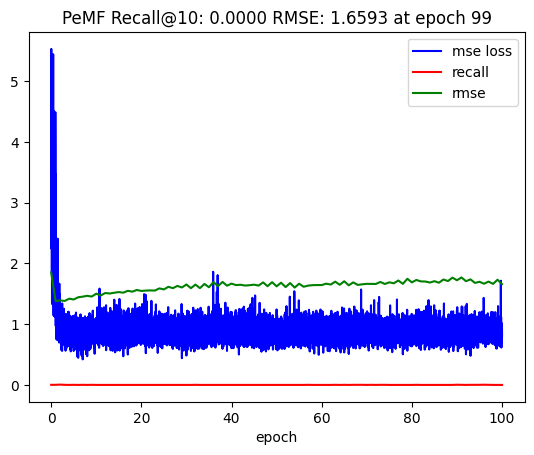

PeMF Recall@10: 0.0000 RMSE: 1.6593 at epoch 99


In [6]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 100
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'PeMF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'PeMF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

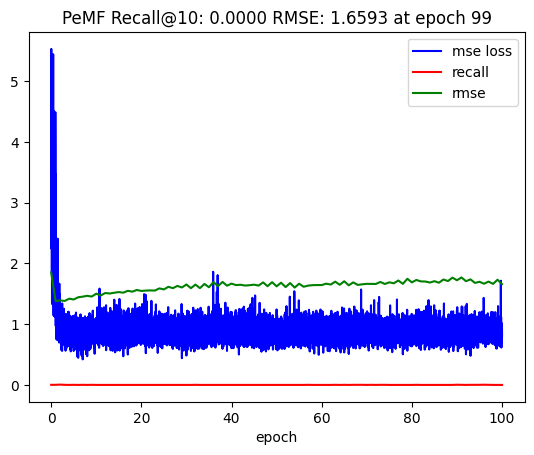

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'PeMF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.savefig(f'./images/PeMF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}.png')
plt.show()

In [8]:
recall_list

[0.001639344262295082,
 0.001639344262295082,
 0.004918032786885246,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003278688524590164,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.003278688524590164,
 0.0016393

In [9]:
rmse_list

[1.8520931336608817,
 1.3784176660605627,
 1.3920821367289289,
 1.3820211872707033,
 1.4193918532358238,
 1.406755314213742,
 1.442924464960457,
 1.4530377105418963,
 1.4672893809735352,
 1.4544999375590826,
 1.5018159682173373,
 1.471548458088266,
 1.5135857932932173,
 1.5045994337698203,
 1.517834419593298,
 1.528482700288684,
 1.5188025759791908,
 1.549252003492236,
 1.535252691835877,
 1.5628494634835641,
 1.5472981038063889,
 1.5529725090094202,
 1.5558269676455585,
 1.5532444529966205,
 1.5890446184590712,
 1.5720320060082837,
 1.6151439636831886,
 1.5927821193624514,
 1.6298463884766925,
 1.603878895432947,
 1.6532869284921397,
 1.5924440156686641,
 1.6517115616815647,
 1.59321076489642,
 1.6622436325770567,
 1.6076803080764175,
 1.6941291441032542,
 1.6243210621325985,
 1.695396386105951,
 1.6337008455290996,
 1.6675490983772134,
 1.6433709552448463,
 1.6488965014658703,
 1.6358455249541295,
 1.641644478985231,
 1.6505553033595215,
 1.6352611961897077,
 1.6876402902568117,
 1.6

In [10]:
# max(recall_list), min(rmse_list) 
print(f'PeMF Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'PeMF Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

PeMF Max Recall@10: 0.0049 at epoch 2
PeMF Min RMSE: 1.3784 at epoch 1
